In [1]:
# import libraries
import os
import tarfile
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import  plot_confusion_matrix,classification_report,roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')


C:\Users\19803\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# import dataset
df_train = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\train.csv', index_col=0)
df_val = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\valid.csv',index_col=0)
df_test = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\test.csv',index_col=0)

In [4]:
df_train.head()     

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [5]:
df_val.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [6]:
df_test.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [7]:
# remove not needed columns and shuffle
df_train = df_train.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_val = df_val.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_test = df_test.drop(columns=['original_path','id','label_str']).sample(frac=1)

# rectify labels
df_train['label'] = 1 - df_train['label']
df_val['label'] = 1 - df_val['label']
df_test['label'] = 1 - df_test['label']

In [8]:
# split datasets by columns
y_train = df_train['label']
X_train = df_train['path']

y_val = df_val['label']
X_val = df_val['path']

y_test = df_test['label']
X_test = df_test['path']

<BarContainer object of 2 artists>

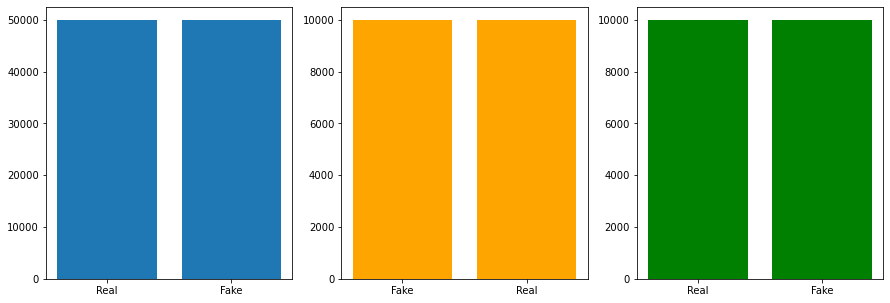

In [9]:
# Check class balance for each dataset
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

<BarContainer object of 2 artists>

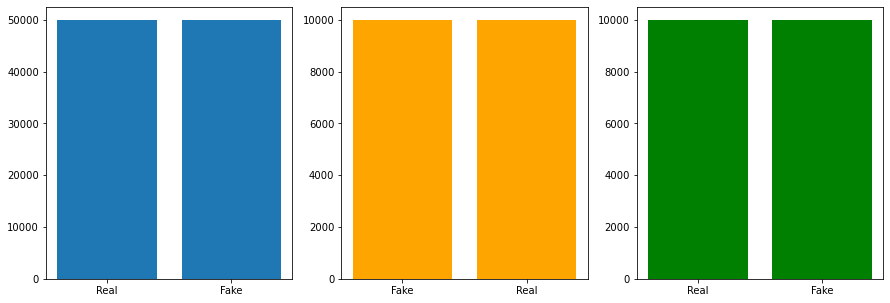

In [10]:
# Check for class balance in extracted data
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

In [11]:
# map each image name to its path

# map each image name to its path
X_train = X_train.map(lambda x: 'C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake' + x)
X_val = X_val.map(lambda x: 'C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake' + x)
X_test = X_test.map(lambda x: 'C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake' + x)

In [12]:
# import numpy as np
# import pandas as pd
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to image files
# X_train = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\train.csv', index_col=0)
# X_val = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\valid.csv', index_col=0)
# X_test = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\test.csv', index_col=0)

# print(X_train['original_path'].values[0])

# # Map each image name to its path
# X_train['original_path'] = X_train['original_path'].map(lambda x: r'C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake' + x)
# X_val['original_path'] = X_val['original_path'].map(lambda x: r'C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake' + x)
# X_test['original_path'] = X_test['original_path'].map(lambda x: r'C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake' + x)

# # # Create a figure with 2 rows and 3 columns of subpots
# # label_arg = {0: 'real', 1: 'fake'}
# # fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# for i in range(2):
#     for j in range(3):
#         random_idx = np.random.randint(0, X_train.shape[0], 1)
#         img_path = str(X_train.iloc[int(random_idx)]['original_path'])
#         img = Image.open(img_path)
#         label = X_train.iloc[int(random_idx)]['label']  # Assuming 'label' is the column containing labels
#         axs[i, j].imshow(img)
#         axs[i, j].set_title(label_arg[label])

# plt.show()


# X_train['original_path'].values
# """
# C:\\Users\\19803\\Downloads\\archive.zip\\real_vs_fake\\real-vs-fake/kaggle/input/flickrfaceshq-dataset-nvidia-part-7/images1024x1024-20191222T221133Z-035/images1024x1024/31000/31355.png'

# This is wrong path, you are running it locally. Do you have kaggle folder in your local?
# """

['C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake\\train\\real\\31355.jpg'
 '31355' 1 'real' 'train/real/31355.jpg']
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\real\61529.jpg
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\fake\VE7KBL51SF.jpg
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\fake\Y5IIQBEX7G.jpg
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\fake\90TNEFU74Z.jpg
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\fake\BNXNPI61N8.jpg
C:\Users\19803\Downloads\archive\real_vs_fake\real-vs-fake\train\fake\YEIERNNETN.jpg


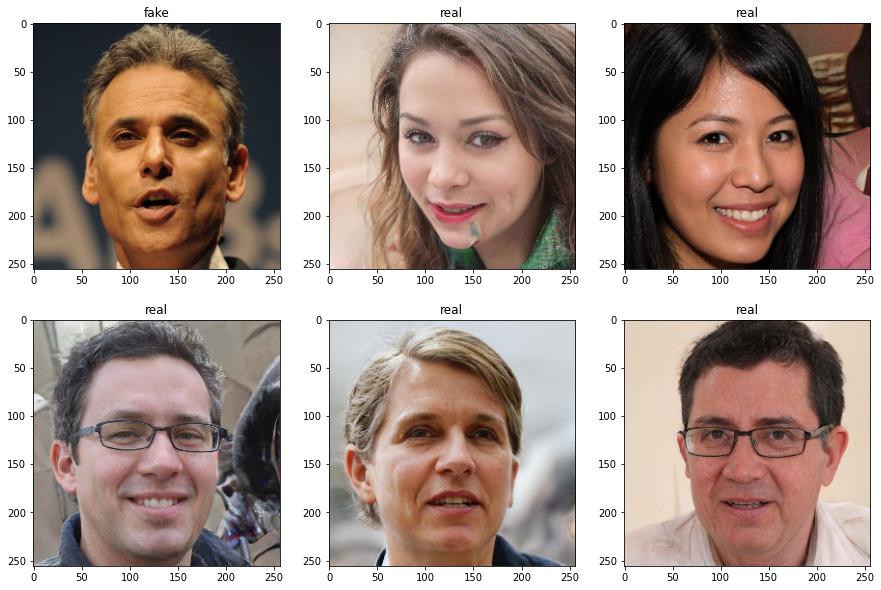

In [13]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Paths to image files
X_train = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\train.csv', index_col=0)
X_val = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\valid.csv', index_col=0)
X_test = pd.read_csv(r'C:\\Users\\19803\\Downloads\\archive\\test.csv', index_col=0)



def format_file_path(string):
    static_path = "C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake\\"
    
    static_path = static_path + string.replace("/", "\\")
    
    return static_path

X_train['original_path'] = X_train['path'].apply(format_file_path)

print(X_train.values[0])

# # Create a figure with 2 rows and 3 columns of subpots
label_arg = {0: 'real', 1: 'fake'}
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(2):
    for j in range(3):
        random_idx = np.random.randint(0, X_train.shape[0], 1)
        img_path = str(X_train.iloc[int(random_idx)]['original_path'])
        print(img_path)
        img = Image.open(img_path)
        label = X_train.iloc[int(random_idx)]['label']  # Assuming 'label' is the column containing labels
        axs[i, j].imshow(img)
        axs[i, j].set_title(label_arg[label])

plt.show()

# Preprocessing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
ig = ImageDataGenerator(rescale=1./255.)
base_path = 'C:\\Users\\19803\\Downloads\\archive\\real_vs_fake\\real-vs-fake\\'
train_flow = ig.flow_from_directory(
    base_path + 'train/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
    base_path + 'valid/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'test/',
    target_size=(128, 128),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# CNN Architecture 

In [15]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[128, 128, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 64)                33554496  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                     

In [16]:
history = model.fit(train_flow, epochs=3,batch_size=64,
                    validation_data= valid_flow)

Epoch 1/3


1563/1563 [==============================] - 2696s 2s/step - loss: 0.8241 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/3
1563/1563 [==============================] - 2606s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/3
1563/1563 [==============================] - 2620s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


# Using Pretrained Model ResNet50 

# Classification Report

In [17]:
from tensorflow.keras.applications import ResNet50

pretrained = ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))
model = t.keras.Sequential([pretrained, 
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(units=512, activation="relu"),
                            tf.keras.layers.Dense(units=2, activation="softmax")
                            ])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

NameError: name 't' is not defined

In [19]:
history = model.fit(train_flow,
    epochs = 3,
    validation_data =valid_flow,
   callbacks= [es])

Epoch 1/3
1563/1563 [==============================] - 8865s 6s/step - loss: 0.1848 - accuracy: 0.9257 - val_loss: 0.3688 - val_accuracy: 0.8447
Epoch 2/3
1563/1563 [==============================] - 8040s 5s/step - loss: 0.0804 - accuracy: 0.9696 - val_loss: 0.1771 - val_accuracy: 0.9341
Epoch 3/3
1563/1563 [==============================] - 8190s 5s/step - loss: 0.0546 - accuracy: 0.9798 - val_loss: 0.4951 - val_accuracy: 0.8551


## Results

Text(0.5, 1.0, 'Accuracy')

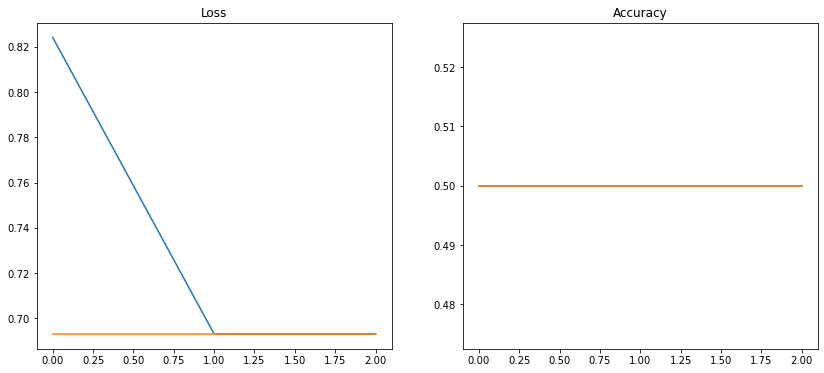

In [19]:
# plot loss and accuracy evolution
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.plot(range(len(history.history['loss'])),history.history['loss'])
ax1.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
ax1.set_title('Loss')
ax2 = plt.subplot(122)
ax2.plot(range(len(history.history['accuracy'])), history.history['accuracy'])
ax2.plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'])
ax2.set_title('Accuracy')

In [18]:
y_pred = model.predict(test_flow)

20000/20000 [==============================] - 341s 17ms/step


In [20]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [21]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_labels))
print("AP Score:", average_precision_score(y_test, y_pred_labels))     
print()
print(classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.5
AP Score: 0.5

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000

